In [1]:
import numpy as np
import torch

from tqdm import tqdm
from matplotlib import pyplot as plt

import seaborn as sns

%load_ext autoreload
%autoreload 2

In [2]:
# If GPUs available, select which to train on
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [ ]:
from utils import generate_run_ID, load_trained_weights
from place_cells import PlaceCells
from trajectory_generator import TrajectoryGenerator
from model import RNN
from trainer import Trainer
from pruner import Pruner

# model prepare

In [4]:
# Training options and hyperparameters
class Options:
    pass
options = Options()

options.save_dir = './models'
options.n_steps = 1000      # number of training steps
options.batch_size = 200      # number of trajectories per batch
options.sequence_length = 20  # number of steps in trajectory
options.learning_rate = 1e-4  # gradient descent learning rate
options.Np = 512              # number of place cells
options.Ng = 4096           # number of grid cells
options.place_cell_rf = 0.12  # width of place cell center tuning curve (m)
options.surround_scale = 2    # if DoG, ratio of sigma2^2 to sigma1^2
options.RNN_type = 'RNN'      # RNN
options.activation = 'relu'   # recurrent nonlinearity
options.weight_decay = 1e-4   # strength of weight decay on recurrent weights
options.DoG = True            # use difference of gaussians tuning curves
options.periodic = False      # trajectories with periodic boundary conditions
options.box_width = 2.2       # width of training environment (m)
options.box_height = 2.2      # height of training environment (m)
options.seed = None           # random seed 

options.run_ID = generate_run_ID(options)
options.device = torch.device('cpu')

In [5]:
# If you've trained with these params before, will restore trained model
place_cells = PlaceCells(options)
model = RNN(options, place_cells)
trajectory_generator = TrajectoryGenerator(options, place_cells)
trainer = Trainer(options, model, trajectory_generator)

Initializing new model from scratch.
Saving to: ./models/steps_20_batch_200_RNN_4096_relu_rf_012_DoG_True_periodic_False_lr_00001_weight_decay_00001


In [6]:
# Load example weights stored on github
weight_dir = options.save_dir + '/example_trained_weights.npy'
load_trained_weights(model, trainer, weight_dir)

Initialized trained weights.
Epoch: 0/1. Step 0/1. Loss: 6.37. Err: 95.5cm
Loaded trained weights.
Epoch: 0/1. Step 0/1. Loss: 6.16. Err: 4.61cm


In [7]:
save_dir = options.save_dir + '/' + options.run_ID + '/data/'
os.makedirs(save_dir, exist_ok=True)
os.chdir(save_dir)

# data prepare

In [8]:
# Load band and grid scores
band_score = np.load('band_score.npy')
grid_score = np.load('grid_score.npy')

In [9]:
# Get indices of cells to prune
band_idx = np.argsort(band_score)[::-1][0:len(np.where(band_score > 5.8)[0])]
grid_idx = np.argsort(grid_score)[::-1][0:len(np.where(np.asarray(grid_score) > 0.88)[0])]
combined_idx = np.concatenate((band_idx, grid_idx))
random_idx = np.arange(0, model.Ng)
neither_idx = np.setdiff1d(random_idx, combined_idx)
n_steps = 30
mask_size = 750

In [ ]:
# Run pruning experiments
pruner = Pruner(model, trajectory_generator)
band_to_grid_recurrent_err = pruner.prun_recurrent(mask_1=band_idx, mask_2=grid_idx, mask_size=mask_size, n_steps=n_steps, step_by_step=True)
grid_to_band_recurrent_err = pruner.prun_recurrent(mask_1=grid_idx, mask_2=band_idx, mask_size=mask_size, n_steps=n_steps, step_by_step=True)

In [ ]:
# Save results
output_dir = 'prune/recurrent/'
os.makedirs(output_dir, exist_ok=True)
np.save(os.path.join(output_dir, 'band_to_grid.npy'), band_to_grid_recurrent_err)
np.save(os.path.join(output_dir, 'grid_to_band.npy'), grid_to_band_recurrent_err)

# plot

### Figure 2d: Pruning the connections from band to grid and the connections from grid to band cells, respectively.

In [10]:
# Load results
dir = 'prune/recurrent/'
band_to_grid_recurrent_err = np.load(os.path.join(dir, 'band_to_grid.npy'))
grid_to_band_recurrent_err = np.load(os.path.join(dir, 'grid_to_band.npy'))

# Create a range for the x-axis, taking every 10th value
x = np.arange(0, len(band_to_grid_recurrent_err))*10

# Calculate the mean and standard deviation of the errors
band_to_grid_err_std = np.std(band_to_grid_recurrent_err, axis=1) / options.box_width
grid_to_band_err_std = np.std(grid_to_band_recurrent_err, axis=1) / options.box_width

band_to_grid_err_mean = np.mean(band_to_grid_recurrent_err, axis=1) / options.box_width
grid_to_band_err_mean = np.mean(grid_to_band_recurrent_err, axis=1) / options.box_width

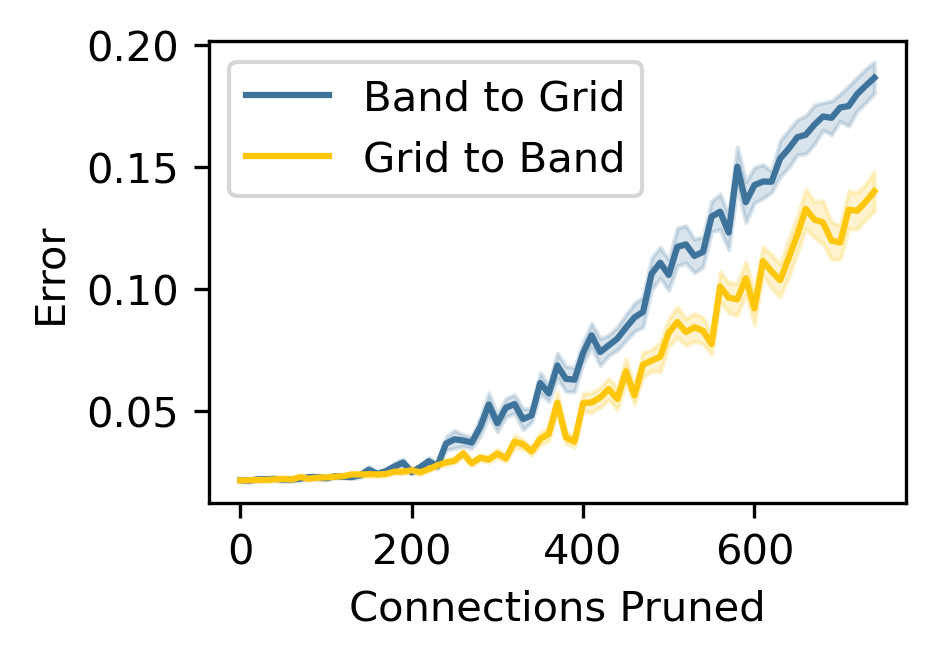

In [11]:
# Plotting
plt.figure(figsize=(3, 2), dpi=300)
plt.rcParams.update({'font.size': 10})

plt.plot(x, band_to_grid_err_mean, label='Band to Grid', color=(62/255, 115/255, 155/255))
plt.fill_between(x, band_to_grid_err_mean - band_to_grid_err_std, 
                 band_to_grid_err_mean + band_to_grid_err_std, alpha=0.2, color=(62/255, 115/255, 155/255))

plt.plot(x, grid_to_band_err_mean, label='Grid to Band', color=(254/255, 198/255, 13/255))
plt.fill_between(x, grid_to_band_err_mean - grid_to_band_err_std, 
                 grid_to_band_err_mean + grid_to_band_err_std, alpha=0.2, color=(254/255, 198/255, 13/255))

# Set the title and axis labels for the plot
plt.xlabel('Connections Pruned')
plt.ylabel('Error')

# Add a legend
plt.legend()

# Display the plot
plt.show()